# <center> A processing and analytics system for microscopy data workflows: the Pycroscopy ecosystem of packages

<center><font size = 3> R. Vasudevan<sup>1,*</sup>, S. M. Valleti,<sup>2</sup> M. Ziatdinov,<sup>1,3</sup> G. Duscher,<sup>4,**</sup> and S. Somnath<sup>5,6</sup> </font></center>

<sup>1</sup>Center for Nanophase Materials Sciences, Oak Ridge National Laboratory \
<sup>2</sup>Bredesen Center for Interdisciplinary Research, University of Tennessee, Knoxville \
<sup>3</sup>Computational Sciences and Engineering Division, Oak Ridge National Laboratory \
<sup>4</sup>Department of Materials Science and Engineering, University of Tennessee, Knoxville \
<sup>5</sup>National Center for Computational Sciences, Oak Ridge National Laboratory \
<sup>6</sup>Current affiliation: McKinsey Consulting Group

## <left> Visualization, Spectral processing and Matrix Factorization with Pycroscopy
    
In this notebook we will go thorugh basics of loading files, visualizing them, fitting spectra to functions, and then more advanced image manipulation and matrix factorization

In [2]:

!pip install pyNSID sidpy SciFiReaders nanonispy gwyfile pycroscopy

  Using cached pyNSID-0.0.7-py2.py3-none-any.whl (12 kB)
     -------------------------------------- 96.4/96.4 kB 783.5 kB/s eta 0:00:00
     ---------------------------------------- 57.6/57.6 kB ? eta 0:00:00
  Using cached nanonispy-1.1.0-py3-none-any.whl (10 kB)
  Using cached gwyfile-0.2.0-py2.py3-none-any.whl (8.9 kB)
  Using cached pycroscopy-0.62.1-py2.py3-none-any.whl (48 kB)
     ---------------------------------------- 2.6/2.6 MB 12.0 MB/s eta 0:00:00
     ---------------------------------------- 1.1/1.1 MB 12.1 MB/s eta 0:00:00
  Using cached ase-3.22.1-py3-none-any.whl (2.2 MB)
     ------------------------------------- 329.1/329.1 kB 19.9 MB/s eta 0:00:00
     ---------------------------------------- 55.8/55.8 kB 3.0 MB/s eta 0:00:00
     --------------------------------------- 14.9/14.9 MB 14.5 MB/s eta 0:00:00
     ------------------------------------- 298.0/298.0 kB 19.2 MB/s eta 0:00:00
     ---------------------------------------- 8.4/8.4 MB 14.8 MB/s eta 0:00:00
    

In [3]:
%matplotlib notebook

In [4]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

import pyNSID
import sidpy as sid
import SciFiReaders as sr
from sidpy.proc.fitter import SidFitter

# Load and Visualize Spectral dataset

Here we load a dataset of I-V curves captured by conductive atomic force microscopy, on a BiFeO3 sample.
The data has been transformed so that we plot not the log of the current density J, as a function of the square root of the electric field. I-V curves plotted in this fashion will be linear if they follow Schottky emission cinduction laws. The dataset was originally presented in the paper <a href = "https://www.nature.com/articles/s41467-017-01334-5"> Vasudevan et al. Nat Commun. 8, 1318 (2017) </a>

Here we will load the file, which was saved as a pyNSID HDF5 file, using SciFiReaders, which reads it into a <i>sidpy.Dataset</i> object

Then we will use the .plot() method of the <i>sidpy.Dataset</i> object for interactive visualization.


<IPython.core.display.Javascript object>


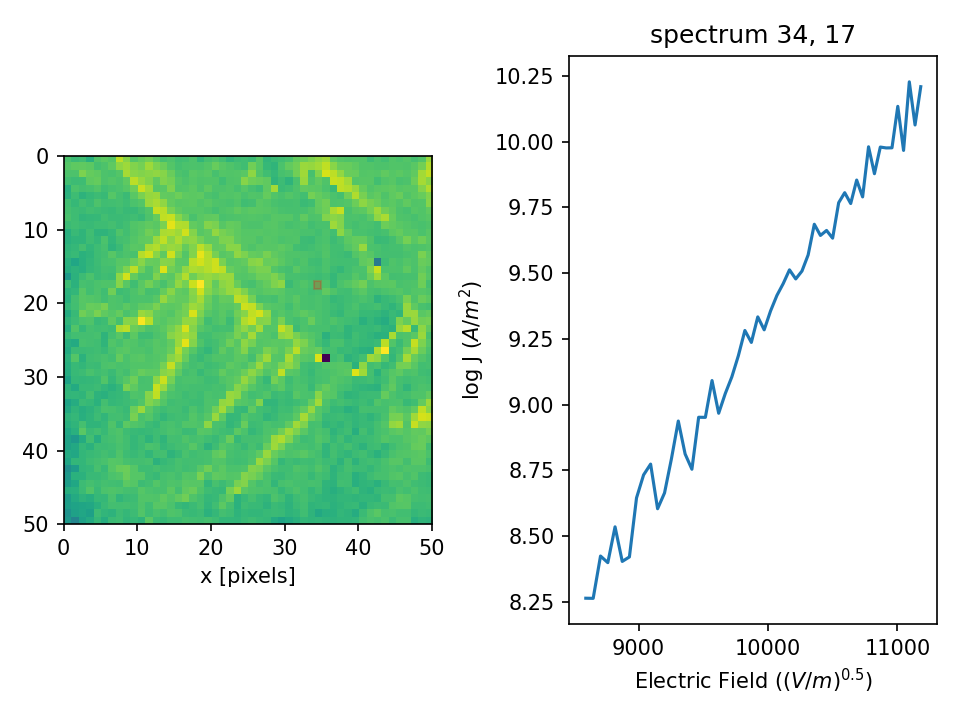

0 DimensionType.SPATIAL
1 DimensionType.SPATIAL
2 DimensionType.SPECTRAL


In [5]:
data_path = r'data/bfo_iv_final.hf5'
dr = sr.NSIDReader(data_path)
dataset_sid = dr.read()[0]
dataset_sid.plot();


# Functional Fitting

Much of the data appears linear. We can define any function of our choice and use sidpy's <i>SidFitter</i> class to make it easy to perform the fit on all of the spectra. We simply define the fit function, instantiate the class, and then call the do_fit() method.

Advantages of using the fitter class include:
- Innate scalability: we leverage the parallelism of Dask, so that the computations are performed in parallel
- Superior priors: We can use a k-means cluster approach to improve priors for the function fits, as described in <a href = "https://iopscience.iop.org/article/10.1088/2632-2153/abfbba/meta">Creange et al.</a>
- Dimension handling: There is intelligent folding and unfolding within the class to handle simple cases. For more complex situations (e.g., when there are multiple spectral dimensions, but only one is used for the fitting), these can be specified too.


In [6]:
#Define the function we want each spectrum to

def one_lin_func(xvec, *coeff):
    a1,a2 = coeff
    return a1*xvec + a2

#Instantiate the SidFitter class
fitter = SidFitter(dataset_sid, one_lin_func,num_workers=4,
                           threads=2, return_cov=False, return_fit=True, return_std=False,
                           km_guess=True,num_fit_parms = 2)

In [7]:
fit_parameters, fitted_dataset = fitter.do_fit() #With one line we can fit all the spectra

C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Visualize Fit Results

We can visualize the parameter maps from the fititng, or visualize the fitted data curves

### Visualize coeffient maps

The functional fits provided us with coefficient maps for the fit parameters.

We can simply call the .plot() method again to visualize them.

<IPython.core.display.Javascript object>


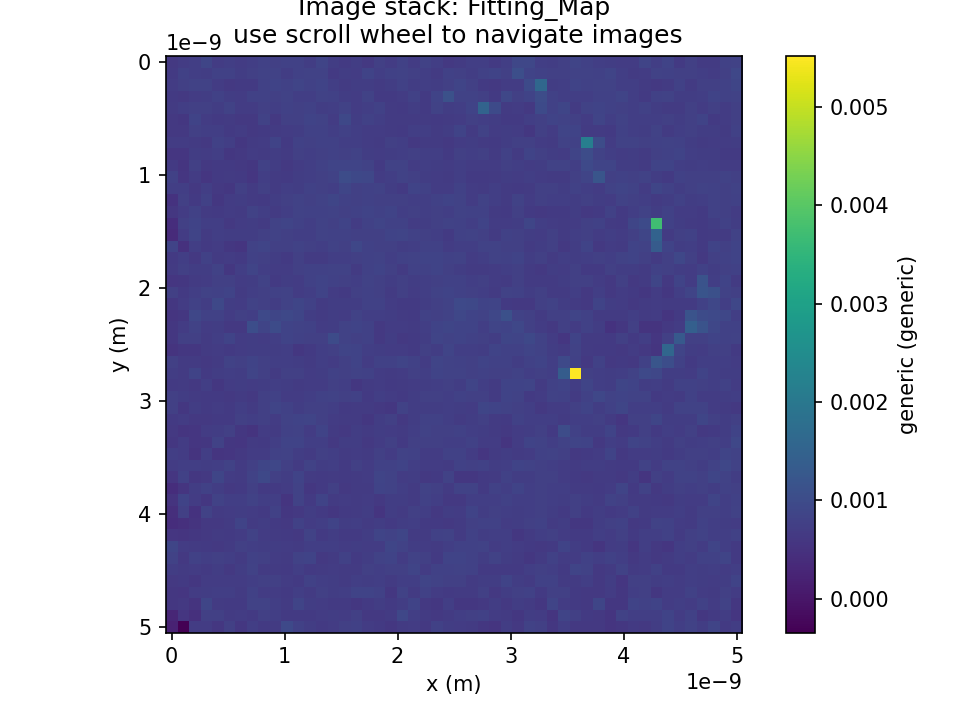

In [8]:
fit_parameters.plot();

### Visualize fitted spectra
Each spectrum is associated with a specific fit. 

We can visualize them again easily
through calling the <i>visualize_fit_results()</i> method of the SidFitter class.

<IPython.core.display.Javascript object>


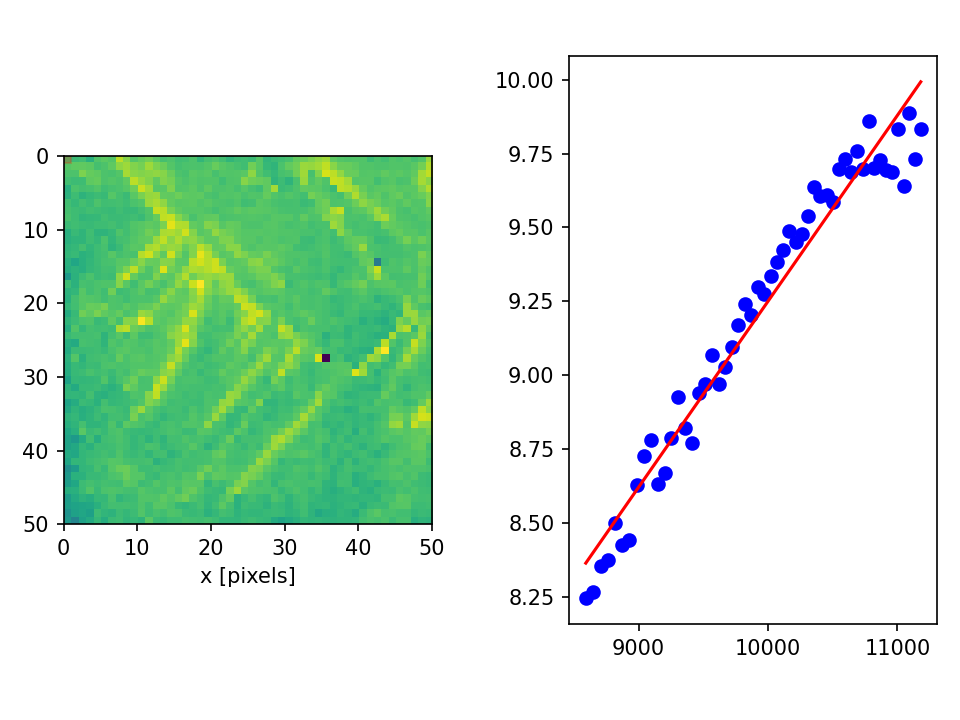

0 DimensionType.SPATIAL
1 DimensionType.SPATIAL
2 DimensionType.SPECTRAL


In [9]:
fitter.visualize_fit_results() # We can visualize the results of the fit interactively too...

# Save the results

We can easily save back to the original HDF5 file. 
This will help us when it comes to e.g., publications -> provide all the necessary data.



In [10]:
import h5py
new_h5_filename = r'new_exp_file.hf5'
hf = h5py.File(new_h5_filename, 'a') #Create a new file

In [11]:
#We can save the fitted results with pyNSID
hf_grp = hf.create_group('Measurement_000/Channel_000') #Create a group

#Let's save the raw data first
pyNSID.hdf_io.write_nsid_dataset(dataset_sid, hf_grp, main_data_name="IV_BFO_Raw")

C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',


<HDF5 dataset "IV_BFO_Raw": shape (50, 50, 53), type "<f8">

In [12]:
fitted_dataset.metadata

{'fit_parms_dict': {'fit_parameters_labels': None,
  'fitting_function': 'def one_lin_func(xvec, *coeff):\n    a1,a2 = coeff\n    return a1*xvec + a2\n',
  'guess_function': 'Not Provided',
  'ind_dims': (0, 1)}}

In [13]:
sid.hdf_utils.print_tree(hf)

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ IV_BFO_Raw
      ----------
      ├ $\sqrt E$
      ├ IV_BFO_Raw
      ├ x
      ├ y


In [14]:
hf_results_grp = hf['Measurement_000/Channel_000/IV_BFO_Raw'] #Let's put the results here.

pyNSID.hdf_io.write_nsid_dataset(fit_parameters, hf_results_grp, main_data_name="IV_BFO_Fit_Parameters")
pyNSID.hdf_io.write_nsid_dataset(fitted_dataset, hf_results_grp, main_data_name="IV_BFO_Fitted_Spectra")

sid.hdf_utils.print_tree(hf) #print result

hf.close()

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ IV_BFO_Raw
      ----------
      ├ $\sqrt E$
      ├ IV_BFO_Fit_Parameters
        ---------------------
        ├ IV_BFO_Fit_Parameters
        ├ fit_parms
        ├ metadata
          --------
          ├ fit_parms_dict
            --------------
        ├ x
        ├ y
      ├ IV_BFO_Fitted_Spectra
        ---------------------
        ├ $\sqrt E$
        ├ IV_BFO_Fitted_Spectra
        ├ metadata
          --------
          ├ fit_parms_dict
            --------------
        ├ x
        ├ y
      ├ IV_BFO_Raw
      ├ x
      ├ y


C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',


# Second example - Image analysis

The pycroscopy package has some tools for generic image analysis, as well as wrappers around common machine learning methods. These include matrix and tensor factorization techniques. Let us explore one example.

First we will import a microscopy image, and then we will perform image windowing

We will then use matrix factorization to analyze the spatial distribution of different phases

This is explained in <a href = "https://pubs.acs.org/doi/full/10.1021/acs.nanolett.6b02130">this article</a>.


In [15]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import pyNSID

import sidpy as sid
import SciFiReaders as sr
from sidpy.proc.fitter import SidFitter

In [16]:
dm3_file = r'data/bto_atomic.dm3'
png_file = r'data/re48.tiff'

dm3_reader = sr.DM3Reader(dm3_file)
img_reader = sr.ImageReader(png_file)

data = dm3_reader.read()[0]

<IPython.core.display.Javascript object>


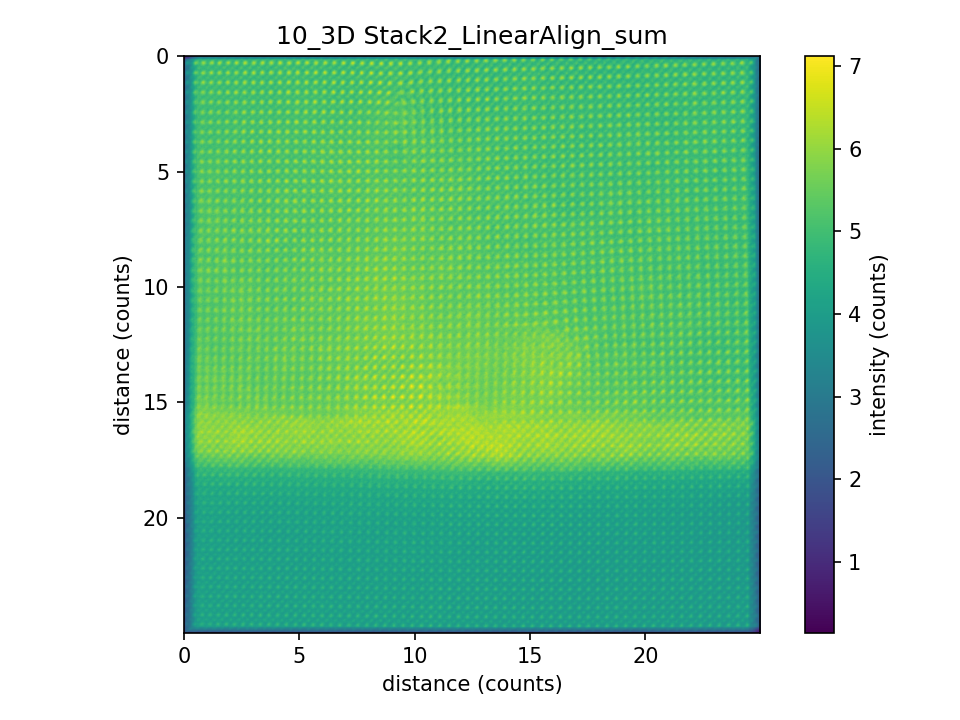

In [17]:
data.plot();

In [18]:
#Let's crop the image and try again
# Make a sidpy dataset

x_dim = data.dim_0.values
y_dim = data.dim_1.values

data_cropped = data[:][200:-200,10:550]

data_set = sid.Dataset.from_array(data_cropped, title='BTO_STEM')

# Set the data type
data_set.data_type = sid.DataType.IMAGE

# Add quantity and units
data_set.units = 'counts'
data_set.quantity = 'Intensity'

y_dim = y_dim[10:550]
x_dim = x_dim[200:-200]

# Add dimension info
data_set.set_dimension(0, sid.Dimension(x_dim,
                                        name='x',
                                        units='nm', quantity='x',
                                        dimension_type='spatial'))
data_set.set_dimension(1, sid.Dimension(y_dim,
                                        name='y',
                                        units='nm', quantity='y',
                                        dimension_type='spatial'))


<IPython.core.display.Javascript object>


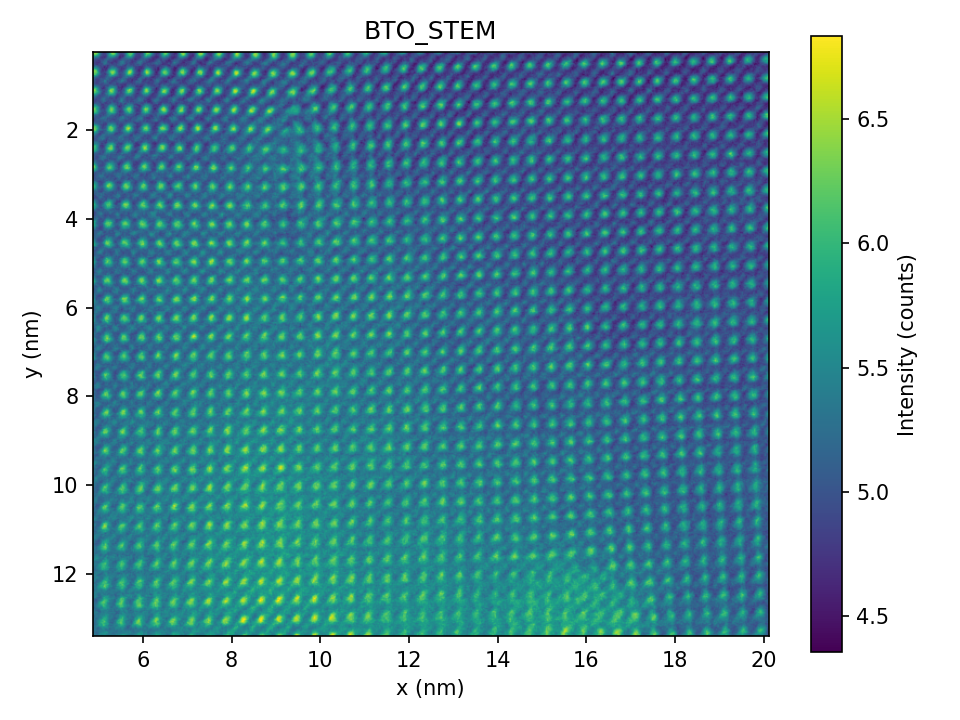

In [19]:
data_set.plot();

In [20]:
from pycroscopy.image import ImageWindowing

parms_dict = {}
parms_dict['window_step_x'] = 8
parms_dict['window_step_y'] = 8
parms_dict['window_size_x'] = 128
parms_dict['window_size_y'] = 128
parms_dict['mode'] = 'fft'
parms_dict['filter'] = 'hamming'
parms_dict['zoom_factor'] = 2
parms_dict['interpol_factor'] = 2
iw = ImageWindowing(parms_dict)
windows = iw.MakeWindows(data_set)
windows = np.abs(np.log(np.abs(windows)))



C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting

C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting

C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting

C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting

C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting

C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting

C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting

C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting

C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting

C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting

C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting

C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting

C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting

C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting

C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting

C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting

C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting

C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting

C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting

C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting

C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting

C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting

C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting

C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting

C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting

C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting

C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting

C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting

C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting

C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting

C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting

C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)
C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\dask\array\core.py:1701: ComplexWarning: Casting

<IPython.core.display.Javascript object>


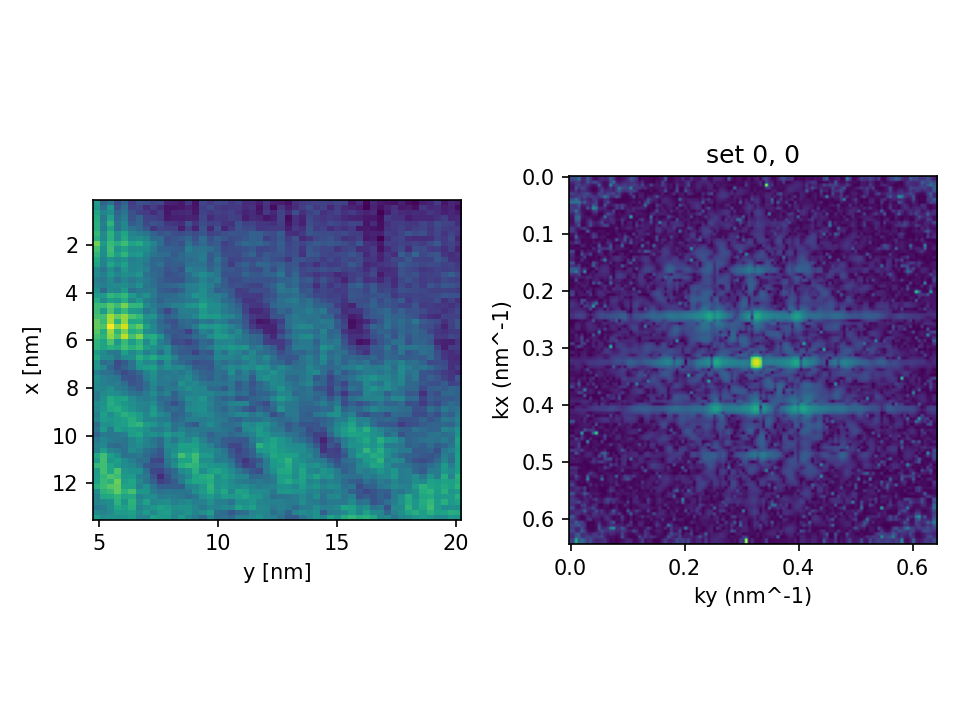

In [21]:
%matplotlib notebook
windows.plot();

In [22]:
from pycroscopy.learn.ml.matrix_factor import MatrixFactor
mfactor = MatrixFactor(np.abs(windows), method = 'nmf',n_components = 2 )
output = mfactor.do_fit()

C:\Users\rvv\Anaconda3\envs\px_testing\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [23]:
abundances = output[0]
components = output[1]
abund = np.array(abundances)
comps = np.array(components)

<IPython.core.display.Javascript object>


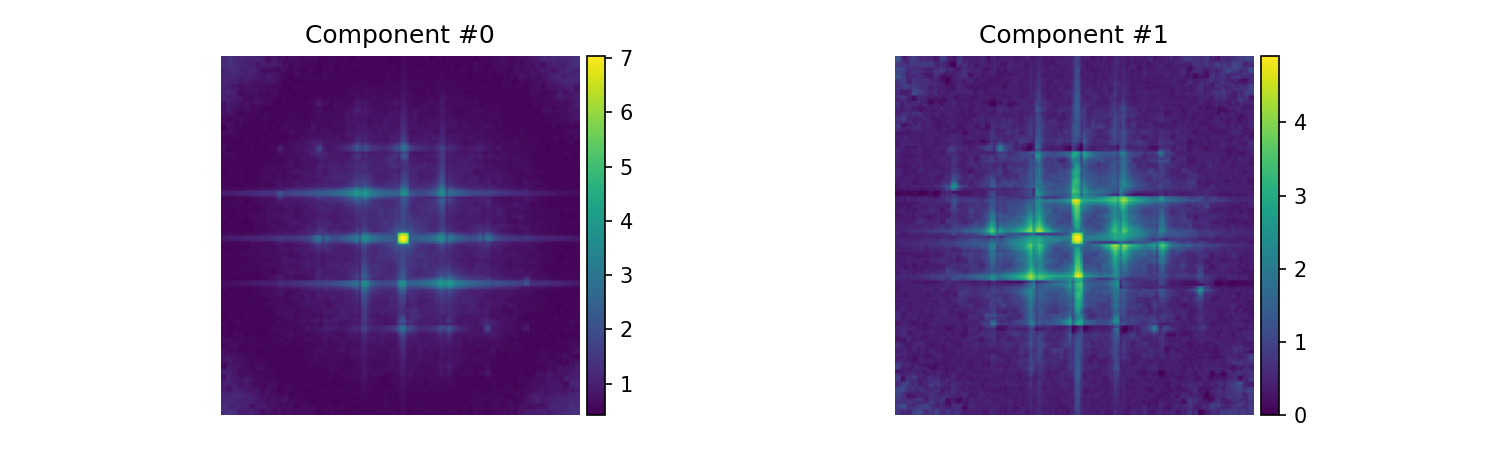

<IPython.core.display.Javascript object>


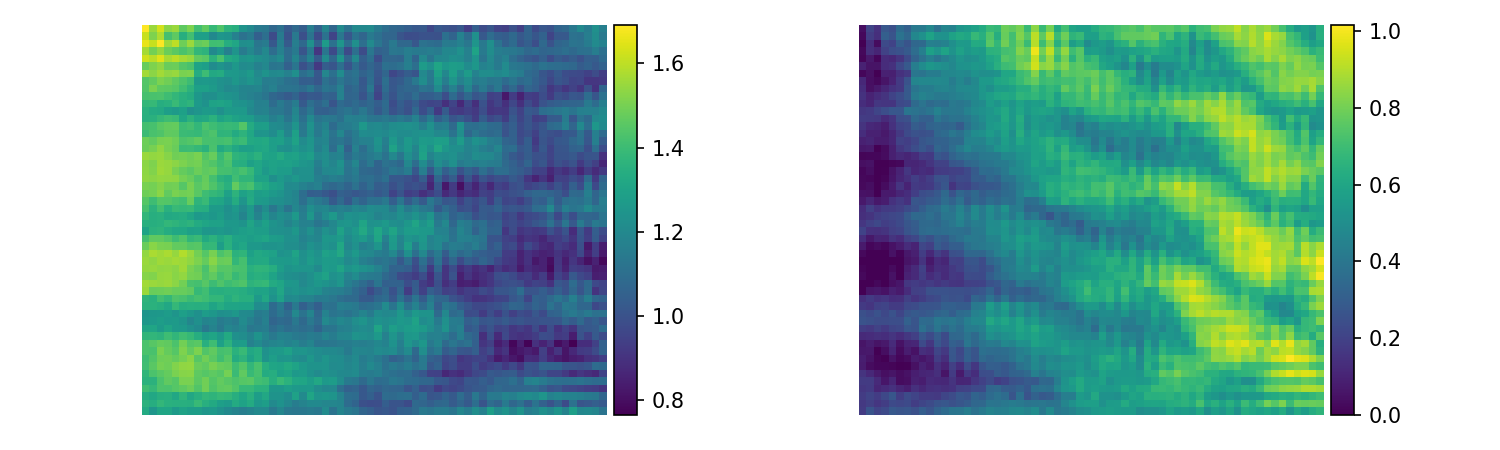

In [24]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axes = plt.subplots(nrows=1, ncols=mfactor.ncomp, figsize = (10,3))
for ind, ax in enumerate(axes.flat):
    im1 = ax.imshow(comps[ind,:,:])
    ax.set_title('Component #' + str(ind))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')
    ax.axis('off')
fig.tight_layout()

fig, axes = plt.subplots(nrows=1, ncols=mfactor.ncomp, figsize = (10,3))
for ind, ax in enumerate(axes.flat):
    im1 = ax.imshow(abund[:,:,ind])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')
    ax.axis('off')

fig.tight_layout()